In [1]:
# SPDX-License-Identifier: Apache-2.0 AND CC-BY-NC-4.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# QEC 101
## Lab 4: Decoders


QEC is only effective if the codes utilized to flag errors can be interpreted to identify the errors to be fixed. This is the job of a decoder.  Decoding is one of the most challenging yet critical aspects of QEC and finding good decoders is a major researcher objective in the field.

This lab introduces the basic concepts of decoding and frames why the problem is so difficult.  In the later sections, you will then work through a number of exercises to implement a naive "brute force" decoder, train an AI decoder, and explore how GPUs can power advanced decoding algorithms like belief propagation with ordered statistics decoding. 


**Prerequisites:** This is the 4th lab in the QEC series. If you are not familiar with the basics of classical or quantum error correction (EC), please complete ["The Basics of Classical and Quantum Error Correction"](https://github.com/NVIDIA/cuda-q-academic/blob/main/qec101/01_QEC_Intro.ipynb) first.  It is also helpful to have completed ["Stabilizers, the Shor Code, and the Steane Code"](https://github.com/NVIDIA/cuda-q-academic/blob/main/qec101/02_QEC_Stabilizers.ipynb) in which stabilizers and syndromes are introduced in detail. This notebook also walks you through building a Steane code implementation in CUDA-Q which is used again in this lab. 

The list below outlines what you'll be doing in each section of this lab:

* **4.1** Understand what decoding is, why it is important, and what makes it so difficult
* **4.2** Explore Pauli frames and error tracking
* **4.3** Code a naive brute force decoder for the Steane Code
* **4.4** Train an AI decoder for the Steane Code
* **4.5** Experiment with NVIDIA's accelerated belief propagation decoder.

Terminology and notation you'll use:
* decoders, decoding window, Pauli frames
* most likely error decoding
* AI decoding
* Belief propagation and ordered statistics decoding

💻 Just a heads-up: This notebook is designed to be run on an environment with a GPU. If you don't have access to a GPU, feel free to read through the cells and explore the content without executing them. Enjoy learning! ⭐

To get started, run the cells below to install the prerequisite libraries and then restart the kernel.

In [2]:
## Instructions for Google Colab. You can ignore this cell if you have cuda-q set up 
# Run this notebook in a GPU runtime
# Uncomment the lines below and execute the cell to install cuda-q

#!pip install cudaq


#!wget -q https://github.com/nvidia/cuda-q-academic/archive/refs/heads/main.zip
#!unzip -q main.zip
#!mv cuda-q-academic-main/qec101/Images ./Images

In [3]:
# install `torch`, 'scikit-learn', 'galois', cudaq-qec' and `ipywidgets` in the current Python kernel. Skip this if they are already installed.
# Make sure to restart your kernel if you execute this!
# In a Jupyter notebook, go to the menu bar > Kernel > Restart Kernel.
# In VSCode, click on the Restart button in the Jupyter toolbar.

import sys

try:
    import torch
    import scikit_learn
    import galois
    import cudaq_qec
    import ipywidgets as widgets
    import numpy as np


except ImportError:
    print("Tools not found, installing. Please restart your kernel after this is done.")
    !{sys.executable} -m pip install --upgrade pip
    !{sys.executable} -m pip install torch
    !{sys.executable} -m pip install scikit-learn
    !{sys.executable} -m pip install galois
    !{sys.executable} -m pip install cudaq-qec
    !{sys.executable} -m pip install ipywidgets
    print("\nNew libraries have been installed. Please restart your kernel!")


#This lab runs a GPU accelerated decoder and requires access to a GPU
import cudaq
cudaq.set_target('nvidia')

Tools not found, installing. Please restart your kernel after this is done.
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.3 MB/s eta 0:00:00 MB/s eta 0:00:01:01
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.7/915.7 MB 56.0 MB/s  0:00:12 eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 55.4 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 67.0 MB/s  0:00:07 eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 81.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 67.6 MB/s  0:00:01 eta 0:00:010:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 50.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 64.6 MB/s  0:00:09 eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 4.1 Decoding Decoded

Remember that a QEC round involves four main steps:
* Encoding logical qubits and sending the system through a noisy channel, which is often just a duration of time where the qubits are exposed to potential sources of error
* Measuring syndrome data
* Decoding the syndrome to identify where an error occurred and what instructions to send to the QPU to fix the error
* Correcting the error

<img src="https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/main/qec101/Images/decoder/decoding.png" alt="Drawing" style="width: 900px;"/>

The decoding step is very challenging and is considered one of the primary limitations for QEC. This is because decoding requires measurements on a QPU, data transfer to the supercomputer, decoding on the supercomputer, and then data transfer back to the QPU.  The time available for this is called the **decoding window** and varies based on a number of factors such as the qubit modality, data transfer rates, and the volume of information that needs to be decoded.

The simulation below makes this more clear.  First, set the time for the decoding window. All 50 syndromes must be decoded in this time, otherwise the QEC procedure fails.  In many cases, syndromes vary in decoding difficulty, so this simulation samples random times from a normal distribution.  Try changing the parameters of the distribution and see how this impacts the decoder's success rate.

Notice how even if a decoder is quite fast and can decode most of the syndromes in time, the worst-case scenario (i.e. hardest syndrome to decode) is usually the limiting factor.

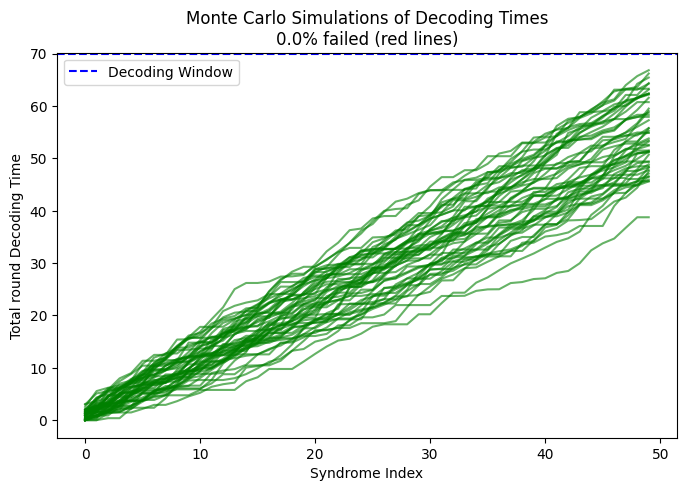

Output()

In [4]:
from Images.decoder.decoder_widget import display_widget
display_widget()

Directly competing with speed is accuracy. If a decoder is inaccurate, errors will be missed or introduced each QEC round and will propagate to ruin the computation. High-distance codes are necessary for accuracy, but unfortunately introduce high-qubit overheads and make decoding much more challenging. Advances in QEC code design and low-latency integration between AI supercomputers and QPUs alleviate pressure on the decoding step, but it nevertheless remains the primary bottleneck of QEC.

## 4.2 Pauli Frames and Error Tracking ##

In practice, when errors are identified by the decoder, they are not immediately corrected but are tracked using a Pauli frame. The Pauli frame keeps track of the corrections classically and applies them later. This approach reduces the number of gate operations required to fix errors on the QPU, thereby protecting the encoded state from additional noise introduced by each correction gate. For instance, if a bit flip error occurs on qubit 1 in the first round and another bit flip error happens on the same qubit later, the two errors cancel each other out, eliminating the need for a correction

Often, codes are depicted using 3D images like the one below. In this case, each plane is a Steane code QEC round with flagged errors in purple. Each error is saved, and the list grows with future rounds. The final Paul frame, $[X_1, X_5, X_1]$, is the list of corrections for the three bit flip errors that have occurred over all the rounds: two on qubit 1 and one on qubit 5.  In the last step, the errors can be simplified, for example, $X_1X_1 = I$, so only one of the three corrections, $X_5$, needs to be applied. This is a rather trivial example, and often diagrams like this are used to depict more complex codes and their respective error pathways.

<img src="Images/decoder/pauliframes.png" alt="Drawing" style="width: 700px;"/>

The dimension of time can also lend itself to more sophisticated decoding schemes. This is particularly important when measurement errors occur during the stabilizer checks. In this case, it might appear that a stabilizer flags when in fact the data qubits are fine. Multiple decoding rounds can demonstrate that the false stabilizer flag is a consequence of measurement error and not a true error, where other true errors would persist without correction. Such an approach is more powerful but requires decoding of much more complex syndromes. The diagram below demonstrates this concept with an example.

<img src="Images/decoder/decodeintime.png" alt="Drawing" style="width: 1000px;"/>
Notice how, in the first case, the decoder has kept track of a measurement error and is therefore making an incorrect syndrome in the final case. When decoding happens over time, the decoding task must not decode a 19-bit syndrome but is able to flag measurement errors



<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px;">
    <h3 style="color: #76b900; margin-top: 0;"> Exercise  1:</h3>
    <p style="font-size: 16px; color: #333;">
The benefit of decoding in time is that the measurement errors can be factored into the decoding process.  However, the tradeoff is that the decoding problem is much harder.  When decoding in time, an effective parity check matrix must be constructed as an input to the decoder. In this exercise you will build $H^{(2)}$ for a two round Steane code that includes consistency checks to  flag errors between the two time steps.  

First, a few hints.  Consider the dimensions. The number of columns still corresponds to the number of qubits, but, now we need to take into account the data qubits at time 0, the data qubits at time 1, and the three ancilla qubits used to measure syndromes between the two rounds. 

Each time step will have the same three stabilizer checks, so $H^{(2)}$ should have six rows. 

The top left block of $H^{(2)}$ and the bottom right block will be $H$, where $H$ is the standard Steane code parity check matrix.

What do the middle three columns need to be for $H^{(2)}$ to be able to catch measurement errors?

Build $H^{(2)}$, and then build an error vector $e$ of size 17 such that each entry is a 0 or a 1 if an error occurred on that qubit.  Compute $H^{(2)}e^T$ for a case with an error on data qubit 1 in the first time step, an error on data qubit 1 in the second time step only, and a measurement error. Note, it is best practice to assume that the decoder will not hanndle raw syndrome outputs, but the differences between he current set of measurements and the next round.  For example, after preparation the syndrome 101 might be measured. If the next round produces the same stabilizer measurerments, the decoder would see 000 not 101. This syntax makes it much easier for decoders to handle data in more complex settings.
    </p>
</div>


In [5]:
import numpy as np 

H = np.array([
    [1, 1, 0, 1, 1, 0, 0],
    [1, 0, 1, 1, 0, 1, 0],
    [0, 1, 1, 1, 0, 0, 1]
])

#Build 2 round parity check matrix.
H2 =  np.array([#TODO
])

#Syndrome for no error
e = np.array([#TODO])

print(H2 @ e.T)

#syndrome for error on first data qubit in first time step
e = np.array([#TODO])

print(H2 @ e.T)

#syndrome for error on first measurement qubit
e = np.array([#TODO])

print(H2 @ e.T)

#syndrome for error on first data qubit in second time step
e = np.array([#TODO])

print(H2 @ e.T)

#Try other errors 

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2539246959.py, line 16)

Looking at your results. Can you see how a measurement error can be detected in the the symdrome pattern? Note that the parity check matrix you created can only catch measurment errors on round 1.  A round 2 measurement error would be missed unless you extenced the parity check matrix further.  

## 4.3 Most Likely Error Decoding

So far, decoders have been presented as black boxes. In many cases that is sufficient.  If you are developing or testing new codes, you might just use a state of the art decoder and not care how it works.  In other cases, the opposite is true, and you might focus on developing and tuning a decoder to work well for a specific sort of QEC situation. 

The rest of this lab will allow you to explore a number of different decoders ranging from conceptually simple to state of the art.  You will interact with them in different ways, in certain cases you'll write the decoder from scratch and at other times you'll use the decoder out of the box. 

The starting point is to consider a naive brute forced decoder that is conceptually simple yet sets the upper bound on decoder accuracy.  

The steps of maximum likelihood decoding are as follows (considering only bitflip errors for simplicity):

1. Select a QEC code and encode a message in the codespace with $n$ data qubits.
2. Generate the $2^n$ bitstrings $\{x_0, \cdots, x_{2^n} \}$ of length $n$ corresponding to all possible error situations.
3. For each $x_i$, compute the syndrome as $Hx_i~\mathrm{mod} 2$ where $H$ is the code's parity check matrix.
4. Then, for each possible syndrome, list errors that could have produced the given syndrome.
5. Under each syndrome, order errors by their Hamming distance from the original message.
6. Finally, the decoder will receive a new syndrome, and then select the lowest Hamming distance error and apply the fix.

The assumption here is that, if errors are independent, cases with fewer errors are always more likely than those with more errors. 

Notice, in Lab 2 when you coded the Steane code, we assumed a situation where one error occurs at a time, allowing your syndrome checks to fix errors.  This is the same assumption made here. The problem with this approach is that it does not scale.  There are $2^n$ errors that need to be computed *a priori* which is not possible for large codes.  The sections below will consider more scaleable heuristics to overcome this issue.


<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px;">
    <h3 style="color: #76b900; margin-top: 0;"> Exercise  2:</h3>
    <p style="font-size: 16px; color: #333;">
Code the most likely error decoder for the Steane code below given the parity check matrix below.  For each syndrome, print the associated length 7 bitstrings that produce that error, the Hamming distance from the baseline message (0000000), and the probability of that error.  
    </p>
</div>
 

In [ ]:
from itertools import product

# Define the bit-flip probability
p = 0.1

# Define the parity check matrix H
H = np.array([
    [1, 1, 0, 1, 1, 0, 0],
    [1, 0, 1, 1, 0, 1, 0],
    [0, 1, 1, 1, 0, 0, 1]
])

# Generate the syndromes and sort based on the instructions above
#TODO

## 4.4 AI Decoders

One way to circumvent the scaling challenges posed by the a brute force most likely error decoder is to use tools like AI. AI is fantastic at pattern recognition, runs very quickly, and can easily scale. 

AI decoders also offer flexibility as they can be trained with simulated data or even trained on small-distance codes and, via transfer learning, be used to decode higher distance codes.

Recently, [NVIDIA and QuEra announced a new transformed based decoder](https://developer.nvidia.com/blog/nvidia-and-quera-decode-quantum-errors-with-ai/) tested on magic state distillation circuits used by QuEra (A 35 qubit circuit with 5 Steane code logically encoded logical qubits).  The decoder showed promise by outperforming the decoder used by QuEra in terms of speed and accuracy.  Additionally, the AI decoder might have the potential to scale to code distances large enough for sufficiently low logical error rates.

<img src="Images/decoder/aidecoderplot.png" alt="Drawing" style="width: 700px;"/>



<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px;">
    <h3 style="color: #76b900; margin-top: 0;"> Exercise  3:</h3>
    <p style="font-size: 16px; color: #333;">
You will now build a working AI decoder for the Steane code. The goal is to build something similar to the workflow in the image below.

<img src="Images/decoder/aidecoderworkflow.png" alt="Drawing" style="width: 700px;"/>

This lab does not expect you to have experience coding AI models with tools like PyTorch, so you will focus on the data generation and learn how to prepare the data to train an AI decoder without worrying about details of the model. Follow the steps outlined below to complete the code.
    </p>
</div>



The first step is to generate the training data. Take the Steane code circuit you coded in Lab 2, now with bitflip noise to each qubit after encoding.  In this case, we can explore circuit-level noise based on simulated results rather than a contrived data set. 

Create a data set of 1000 samples.  To generate this, run `cudaq.sample()` 2000 times taking one shot each time.  Output the measurements from the syndrome checks (without correcting any errors) and then measure all of the data qubits.  Compute the parity of bits corresponding to the correct logical operator to determine the true logical state.  

Save the syndromes and the logical states as two numpy arrays.  This will be your data set.

In [ ]:
import cudaq
import numpy as np

p = 0.2
cudaq.unset_noise()
noise = cudaq.NoiseModel()

@cudaq.kernel
def steane_code():
    """Prepares a kernel for the Steane Code
    Returns
    -------
    cudaq.kernel
        Kernel for running the Steane code
    """   
    data_qubits = cudaq.qvector(7)
    ancilla_qubits = cudaq.qvector(3)

    # Create a superposition over all possible combinations of parity check bits
    h(data_qubits[4])
    h(data_qubits[5])
    h(data_qubits[6])

    #Entangle states to enforce constraints of parity check matrix

    x.ctrl(data_qubits[0],data_qubits[1])
    x.ctrl(data_qubits[0],data_qubits[2])

    x.ctrl(data_qubits[4],data_qubits[0])
    x.ctrl(data_qubits[4],data_qubits[1])
    x.ctrl(data_qubits[4],data_qubits[3])

    x.ctrl(data_qubits[5],data_qubits[0])
    x.ctrl(data_qubits[5],data_qubits[2])
    x.ctrl(data_qubits[5],data_qubits[3])

    x.ctrl(data_qubits[6],data_qubits[1])
    x.ctrl(data_qubits[6],data_qubits[2])
    x.ctrl(data_qubits[6],data_qubits[3])

    for j in range(7):
        cudaq.apply_noise(cudaq.XError, p, data_qubits[j])

    # Detect X errors
    h(ancilla_qubits)

    z.ctrl(ancilla_qubits[0],data_qubits[0])
    z.ctrl(ancilla_qubits[0],data_qubits[1])
    z.ctrl(ancilla_qubits[0],data_qubits[3])
    z.ctrl(ancilla_qubits[0],data_qubits[4])

    z.ctrl(ancilla_qubits[1],data_qubits[0])
    z.ctrl(ancilla_qubits[1],data_qubits[2])
    z.ctrl(ancilla_qubits[1],data_qubits[3])
    z.ctrl(ancilla_qubits[1],data_qubits[5])

    z.ctrl(ancilla_qubits[2],data_qubits[1])
    z.ctrl(ancilla_qubits[2],data_qubits[2])
    z.ctrl(ancilla_qubits[2],data_qubits[3])
    z.ctrl(ancilla_qubits[2],data_qubits[6])

    h(ancilla_qubits)


# Generate Data
TODO

Your data set will be split into a 2000 point training set and a 400 point test set to validate that the model worked.  The inputs to the model will be syndrome data obtained from your simulations.  The loss function will be a comparison between the predicted logical state of the model and the logical state you obtained from measuring the data qubits. 

If you defined the arrays properly, the code below should preprocesses the data for you, splitting it into a training and test set, construct a simple neural network, define model setting, and train the model.

Each epoch is one trining loop through the entire data set.  The model will then test the accuracy using the test set which was excluded from training at each epoch. The code is provided for the interested reader to see the details of the torch implementation, can also just be run as a black box. Do the plots below indicate the model improved as training progressed?

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# This section normalizes and loads the data you defined previously
syndromes = np.array(syndromes, dtype=np.float32)
logical_flips = np.array(logical_flips, dtype=np.float32)

# Normalize input data
syndromes = (syndromes - syndromes.mean()) / syndromes.std()

X_tr, X_te, y_tr, y_te = train_test_split(
    syndromes, logical_flips, test_size=0.20, random_state=42)

X_tr = torch.tensor(X_tr)
X_te = torch.tensor(X_te)
y_tr = torch.tensor(y_tr)
y_te = torch.tensor(y_te)

# Create data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_tr, y_tr),
    batch_size=batch_size,
    shuffle=True
)

# This builds a simple NN model which will be trained
class SimpleDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.act = nn.Sigmoid()
        
        # Initialize weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.act(self.fc3(x))

model = SimpleDecoder()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=10)

# Define the test_accuracy function
def test_accuracy():
    model.eval()
    with torch.no_grad():
        pred = (model(X_te).squeeze() > 0.5).float()
        return (pred == y_te).float().mean().item()

# Training loop
num_epochs = 30
train_losses, test_acc = [], []

# epoch 0 (untrained)
test_acc.append(test_accuracy())

for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = 0
    batch_count = 0
    
    # Training
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        out = model(batch_X).squeeze()
        loss = criterion(out, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        batch_count += 1
    
    # Calculate average loss for the epoch
    avg_epoch_loss = epoch_loss / batch_count
    train_losses.append(avg_epoch_loss)
    
    # Evaluate accuracy
    current_acc = test_accuracy()
    test_acc.append(current_acc)
    
    # Update learning rate
    scheduler.step(avg_epoch_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d}/{num_epochs} | "
              f"train loss={avg_epoch_loss:.4f} | "
              f"test acc={current_acc:.4f}")

# Plotting
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(range(num_epochs + 1), test_acc, marker='o')
plt.xlabel("Training Epoch")
plt.ylabel("Test Accuracy")
plt.title("Steane-Code Decoder Accuracy")
plt.grid(True)
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, color='red')
plt.xlabel("Training Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Over Time")
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
print(f"\nFinal Results:")
print(f"Final Test Accuracy: {test_acc[-1]:.4f}")
print(f"Final Training Loss: {train_losses[-1]:.4f}")

# Print first 20 predictions
model.eval()
with torch.no_grad():
    test_predictions = model(X_te).squeeze()
    predicted_labels = (test_predictions > 0.5).float()

print("\nFirst 20 test examples:")
print("=" * 40)
print(f"{'Index':^6} | {'True':^6} | {'Predicted':^6}")
print("=" * 40)

for i in range(20):
    true_label = int(y_te[i].item())
    pred_label = int(predicted_labels[i].item())
    print(f"{i:^6} | {true_label:^6} | {pred_label:^6}")

print("=" * 40)

# Calculate accuracy for these 20 examples
correct = (predicted_labels[:20] == y_te[:20]).sum().item()
print(f"\nAccuracy for these 20 examples: {correct}/20 = {correct/20:.2%}")



Training AI decoders is a very challenging task and must be used in the proper setting. For example, if the error rate in the training data is very low, The AI model could discover that it can produce pretty good results just by predicting no error each time.  This sort of model does not learn anything about decoding!  Thus, expert care must go into the fine-tuning and validation of AI decoders to ensure they are working properly. The steane code is rather simple and with only $2^7$ possible errors the training data can cover all possible errors. AI decoders in practice can only be trained on a subset of the possible errors, yet must be able to learn enough to decode with high enough accuracy. 

Also note, that not matter how good the AI decoder is, it cannot overcome the fact that the Steane code is distance three.

## Belief Propagation Decoding

Another state-of-the-art decoding method is belief propagation (BP).  BP is a powerful technique borrowed from classical error correction that is highly flexible and can serve as a black box decoder for arbitrary QEC Codes. It is particularly useful for codes like quantum low-density parity check (qLDPC). All the user needs to do is provide a parity check matrix and then feed the decoder syndromes to decode. 

NVIDIA created a GPU accelerated BP decoder which allows researchers to push QEC even further than before.  This section will walk you through implementing BP and how to use NVIDIA's accelerated BP decoder. 

At a high level, BP works by taking initial beliefs about each data qubit's physical error rate and, using syndrome measurements, iteratively update these beliefs to converge on a solution which provides a likelihood of an error occurring or not.  

Though there are different variations of BP, one implementation is the following:
1. Initialize a log-likelihood ratio $L_{v_i} = log(\frac{1-p}{p})$ for each data qubit $v_i$ where $p$ is the physical error rate.  If an error is unlikely, the quantity is positive and increases in magnitude the smaller $p$ is as errors are less likley.
   
2. $L_{v_i\rightarrow c_j}$, the message sent from each data qubit to a check qubit, is calculated based on the following equation:  $L_{v\rightarrow c} = L_i + \sum_{k \in N(i)/j} L_{c_k\rightarrow v_i}$ where $\sum_{k \in N(i)/j}$ includes all of the check qubits connected to data qubit $v_i$ excluding check qubit $c_j$. That is, the check qubit is updated with beliefs the variable learned from the *other* check qubits it is connected to.

   
3. Similarly, $L_{c_j\rightarrow v_i}$ is computed to compute the messages sent back to the variable qubits using $L_{c_j \to v_i} = (-1)^{s_j} \cdot 2 \cdot \text{arctanh} \left( \prod_{k \in N(j) \setminus i} \tanh \left( \frac{L_{v_k \to c_j}}{2} \right) \right)$ where $N(j) \setminus i$ is all *other* variable nodes connected to $c_j$ excluding $v_i$ and $s_j$ is the value of the syndrome measurement for $c_j$.
   
4. Finally, the final beliefs $L_{\text{final}, i}$ are computed as $L_i + \sum_{j \in N(i)} L_{c_j \to v_i}$, summing the prior beliefs with the final messages sent to each variable node. From this a decision can be made where positive numbers indicate no error and negative an error, with the magnitudes related to confidence.

Ideally, BP will converge to a solution that agrees with the original syndrome and correct the error.  If BP cannot converge, it means there is still significant uncertainty whether some of the bits have errors or not and postprocessing is necessary to refine the result.  This will be discussed in the following section.


div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px;">
    <h3 style="color: #76b900; margin-top: 0;"> Exercise  4:</h3>
    <p style="font-size: 16px; color: #333;">
Below is the start of a BP implementation for decoding the 5-qubit repetition code. Fill in the sections marked "TODO" to complete the code.  Most of the BP loops are calculated for you.  Make sure to review them and understand what is going on.  Then, you will complete the code by fixing the code to calculate the final belief on each qubit and determine where errors occurred.
    </p>
</div>


In [ ]:
import numpy as np
import sys

physical_error_rate = 0.1
max_iter = 5

H = np.array([
    [1, 1, 0, 0, 0],  
    [0, 1, 1, 0, 0],  
    [0, 0, 1, 1, 0],  
    [0, 0, 0, 1, 1]   
], dtype=int)

n_qubits = H.shape[1]
n_checks = H.shape[0]

actual_error = np.array([0, 0, 1, 0, 0])

syndrome = H @ actual_error % 2

print("--- Simulation Setup ---")
print(f"Physical Error Rate (p): {physical_error_rate}")
print(f"Actual Error Vector:     {actual_error}")
print(f"Resulting Syndrome:      {syndrome}")
print("-" * 40 + "\n")


#Initialize the prior probabilites, and matricies for v -> c and c -> v messages
L_prior = np.log((1 - physical_error_rate) / physical_error_rate)

L_v_to_c = np.zeros((n_qubits, n_checks))

L_c_to_v = np.zeros((n_checks, n_qubits))


print("--- Initialization ---")
print(f"Prior LLR (L_i) for all qubits: {L_prior:.4f}\n")



for iteration in range(max_iter):
    print(f"--- Iteration {iteration + 1} ---")


    # Compute L_{v_i -> c_j} = L_i + sum_{k in N(i)\j} L_{c_k -> v_i}
    # The message is the qubit's own belief (prior) plus all incoming messages from checks
    
    for i in range(n_qubits):
        for j in range(n_checks):
            if H[j, i] == 1:
                connected_checks = np.where(H[:, i] == 1)[0]
                sum_incoming_L = 0
                for k in connected_checks:
                    if k != j:
                        sum_incoming_L += L_c_to_v[k, i]
                L_v_to_c[i, j] = L_prior + sum_incoming_L
    
    print("Step A: Updated Variable-to-Check Message Matrix (L_v_to_c):")
    print(np.round(L_v_to_c, 4))
    print("")


    # Compute L_{c_j -> v_i} = (-1)^s_j * 2 * atanh( product_{k in N(j)\i} tanh(L_{v_k -> c_j}/2) )
    # The message is based on the check's syndrome value and all of the incoming messages from the data qubits.

    for j in range(n_checks):
        for i in range(n_qubits):
            if H[j, i] == 1:
                connected_qubits = np.where(H[j, :] == 1)[0]
                prod_tanh = 1.0
                for k in connected_qubits:
                    if k != i:
                        # tanh can be unstable for large LLRs, so we clip its argument
                        val = np.clip(L_v_to_c[k, j] / 2, -20, 20)
                        prod_tanh *= np.tanh(val)

                sign = (-1)**syndrome[j]
                
                # FIX IS HERE: Clip prod_tanh to avoid arctanh(1) or arctanh(-1)
                # This defines the missing variable 'prod_tanh_clipped'
                epsilon = 1e-12
                prod_tanh_clipped = np.clip(prod_tanh, -1 + epsilon, 1 - epsilon)

                L_c_to_v[j, i] = sign * 2 * np.arctanh(prod_tanh_clipped)



    print("Step B: Updated Check-to-Variable Message Matrix (L_c_to_v):")
    print(np.round(L_c_to_v, 4))
    print("")


# TODO Compute the final belief of each qubit (prior beliefs plus sum of incoming messages)


#TODO END

print("--- Final Belief ---")
print(f"Final LLRs: {np.round(L_final, 4)}")


estimated_error = #TODO

print("-" * 40)
print(f"Decoder Estimated Error:  {estimated_error}")

if np.array_equal(actual_error, estimated_error):
    print("\n✅ Success: The decoder correctly identified the error.")
else:
    print("\n❌ Failure: The decoder did not find the correct error.")

The 5-qubit repetition code is small, and easy to decode.  If more than one error is present, the BPO decoder will fail, as the code distance is the primary constraint. However, with more complex codes, BP may complete, but not converge, meaning uncertainty remains on some of the bits and a logical error may occur due to its failure. Also, decoding large codes with orders of magnitude more variable and check nodes can become cumbersome. 

NVIDIA's accelerated BP decoder, now part of the CUDA-Q QEC library, helps address this problem and parallelizes the BP algorithm.  Examining your code above, it is not hard to see how the message calculations can be trivially parallelized, making them well suited for GPU acceleration. 

Try running NVIDIA's accelerated BP decoder by running the code below which imports a data set of syndrome data from a large qLDPC code.  How long did it take to decode 10 shots?  


In [ ]:
import requests
import bz2
import os
from Images.decoder.bp import run_decoder, parse_csr_mat, parse_H_csr, parse_obs_csr

if __name__ == "__main__":
    # See other test data options in https://github.com/NVIDIA/cudaqx/releases/tag/0.2.0
    filename = 'osd_1008_8785_0.001.json' # lower error rate
    bz2filename = filename + '.bz2'
    if not os.path.exists(filename):
        url = f"https://github.com/NVIDIA/cudaqx/releases/download/0.2.0/{bz2filename}"
        # Download the file
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an error if download fails
        with open(bz2filename, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)

        print(f'Decompressing {bz2filename} into {filename}')

        # Decompress the file
        with bz2.BZ2File(bz2filename, "rb") as f_in, open(filename,
                                                          "wb") as f_out:
            f_out.write(f_in.read())

        print(f"Decompressed file saved as {filename}")

In [ ]:
if __name__ == "__main__":
    num_shots = 10
    run_as_batched = True
    print_output = True
    osd_method = 0 # 0 is off 1 is on
    run_decoder(filename, num_shots, run_as_batched, print_output, osd_method)

One of the reasons this algorithm can be accelerated is that it can be naturally parallelized. Do you see where that might happen?  

The answer lies in the process of sending messages from syndrome qubits to data qubits, and vice versa. Each of these messages can be computed in parallel. This corresponds to performing operations that alternate across the rows and columns of a matrix, depending on which message is being sent. Each row and column can be treated independently, allowing for further parallelization within each row or column.

In benchmarks of large code instances, the NVIDIA decoder was up to 35x faster than the industry standard implementation for benchmarks run on the [[144,12,12]](https://arxiv.org/abs/2308.07915) code. 

<img src="Images/decoder/benchmark.png" alt="Drawing" style="width: 700px;"/>



### Batching

The performance can be enhanced ever further using batching.  Batching means that a collection of syndromes are sent to the GPU and decoded simultaneously.  This minimizes data transfer and allows the entire GPU to be working, reducing the average decoding time per shot.  

Run the cells below to see the impact of batching when decoding 10000 syndromes. In the second cell, `run_as_batched` is set to `True`. How much faster is batching?  Batching is most effective when decoding a large number of syndromes.

In [ ]:
if __name__ == "__main__":
    num_shots = 10000
    run_as_batched = False
    print_output = False
    osd_method = 0 # 0 is off 1 is on
    run_decoder(filename, num_shots, run_as_batched, print_output, osd_method)

In [ ]:
if __name__ == "__main__":
    num_shots = 10000
    run_as_batched = True
    print_output = False
    osd_method = 0 # 0 is off 1 is on
    run_decoder(filename, num_shots, run_as_batched, print_output, osd_method)

### Ordered Statistics Decoding
Now, increase the error rate using a different data file from 0.1 % to 0.5 %.  What happens to the logical error rate? 

In [ ]:
import requests
import bz2
import os
from Images.decoder.bp import run_decoder, parse_csr_mat, parse_H_csr, parse_obs_csr

if __name__ == "__main__":
    # See other test data options in https://github.com/NVIDIA/cudaqx/releases/tag/0.2.0
    filename = 'osd_1008_8785_0.005.json' # lower error rate
    bz2filename = filename + '.bz2'
    if not os.path.exists(filename):
        url = f"https://github.com/NVIDIA/cudaqx/releases/download/0.2.0/{bz2filename}"
        # Download the file
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an error if download fails
        with open(bz2filename, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)

        print(f'Decompressing {bz2filename} into {filename}')

        # Decompress the file
        with bz2.BZ2File(bz2filename, "rb") as f_in, open(filename,
                                                          "wb") as f_out:
            f_out.write(f_in.read())

        print(f"Decompressed file saved as {filename}")

In [ ]:
if __name__ == "__main__":
    num_shots = 10000
    run_as_batched = True
    print_output = False
    osd_method = 0 # 0 is off 1 is on
    run_decoder(filename, num_shots, run_as_batched, print_output, osd_method)

You should notice a very high logical error rate. Each of these logical error rates is a case where BP could not converge.  Like any numerical solver, it is possible to increase iterations and perform a number of tricks to help BP, but some particularly difficult syndromes will not converge either way. To solve this, BP decoders are often paired with optional ordered statistics decoding (OSD) which performs post-processing to improve the result.  Thus, you might often see a "BP+OSD" decoder. 

The intuition behind OSD decoding is to solve for the errors directly using matrix inversion.  That is, solving $e = H^{-1}s$ where $e$ is a vector with error locations, $s$ is the syndrome, and $H$ is the parity check matrix.  The procedure cannot be performed with the original $H$, so instead, a square matrix with columns of full-rank must be constructed from the columns of $H$. 

What makes this approach challenging is selecting the right columns.  Many different solutions can be obtained with different column selections, but without guidance, this will likely result in a solution that is not of minimum weight and induce a logical error. Recall, for the most likely error decoder above, that valid errors with high weight are much less likely than low weight errors.  Same idea here, but rather than computing all combinations, the OSD heuristic provides a clever way to search from a really good starting point that is the output of BP. 

The output of BP assigns a probability of error to each data qubit.  This naturally informs the reordering of the columns to rank from most to least likely to have an error. Next Gaussian elimination is performed on $H$ to determine the first full columns of full rank. These subcolumns are then inverted to get $H^{-1}$ which is multiplied by $s$ to get the error result $e_{[s]}$. The $e_{[s]}$ is then padded with zeros  $e_{[T]} =0$ which results in a total error profile of $ e = (e_{[s]},e_{[T]})$.  



<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px;">
    <h3 style="color: #76b900; margin-top: 0;">Exercise 5:</h3>
    <p style="font-size: 16px; color: #333;">
        The following exercise is based on a <a href="https://www.youtube.com/watch?v=b9N2Ps3FTto" target="_blank" style="color: #76b900; text-decoration: underline;">lecture</a> by Joschka Roffe. Given the parity check matrix below and the probabilities of error from BP. Perform OSD manually and find the error profile that satisfies the syndrome. Note, all computations must be performed using mod 2 arithmetic. This can be accomplished using the <code>galois</code> library which creates a Galois field and allows all <code>numpy</code> operations to compute mod 2.
    </p>
</div>


In [ ]:
GF2 = galois.GF(2) # allows mod 2 math.

#parity check matrix as numpy array
H = np.array([[0, 1, 0, 0, 1, 0],
              [0, 0, 1, 0, 0, 1],
              [1, 0, 0, 1, 0, 0],
              [1, 0, 0, 0, 1, 1]])

bp_results = [0.05, 0.5, 0.01, 0.01, 0.82, 0.05]

s = GF2([1,0,0,1]) #syndrome

# Get indices that would sort bp_results in descending order
#TODO

# Rearrange columns of numpy array
#TODO
H_sorted = 


# Convert to GF2 matrix after rearrangement for mod 2 aritmatic
GF2 = galois.GF(2)
H_sorted = GF2(H_sorted)

# Perform Gaussian elimination to identify the first four columns of full rank.
def rref(matrix):
    rows, cols = matrix.shape
    r = 0
    for c in range(cols):
        if r >= rows:
            break
        if matrix[r, c] == 0:
            for i in range(r + 1, rows):
                if matrix[i, c] != 0:
                    matrix[[r, i]] = matrix[[i, r]]
                    break
        if matrix[r, c] == 0:
            continue
        matrix[r] = matrix[r] / matrix[r, c]
        for i in range(rows):
            if i != r and matrix[i, c] != 0:
                matrix[i] = matrix[i] - matrix[i, c] * matrix[r]
        r += 1
    return matrix

print("Gaussian Elimination Result")
print(rref(H_sorted.copy())) # First four columns are pivot columns

# Build H_s from the first full rank columns
#TODO

# Compute Hs_inverse
#TODO

# Calculate e_s
#TODO

# Pad result with zeros and reorder based on colum sorting from earlier.
#TODO

# Confirm that the errors produce the expected syndrome from the original H
#TODO

from Images.decoder.solution3_button import show_cudaq_solution
show_cudaq_solution()

OSD guarantees an error pattern that satisfies the syndrome, but it is not necessarily a minimum weight solution nor avoids a logical error. In the exercise above, you performed OSD-0, or zero order OSD.  To improve results, higher order OSD can be performed.  Higher order OSD performs bitflips in the $e_{[T]}$ bits and checks if a lower weight solution can be found. Generally speaking, the order of the OSD determines how many bitflips are considered, but there is additional nuance not covered here. 

Lower weight solutions are possible as bit flips in $e_{[T]}$ also impact the other bits in the $e_{[s]}$ subspace. 

To summarize, syndromes are of varying difficulty. Easy syndromes are solved with BP, OSD-0 is used for moderate syndrome difficulties, and higher order OSD is used for the most challenging.  


<img src="Images/decoder/bposd.png" alt="Drawing" style="width: 1000px;"/>


Try running the code below on the 10000 shot data set.  See what happens when `osd_method` is set to 1 for OSD-0.  Then try setting this variable to 3 to run a variant of higher order OSD.  Does the logical error rate improve?  How much more time does it take to perform higher order OSD?

In [ ]:
if __name__ == "__main__":
    num_shots = 10000
    run_as_batched = True
    print_output = False
    osd_method = 1  # 0 is off, 1 OSD-0, 3 is OSD-X, where X is the order
    run_decoder(filename, num_shots, run_as_batched, print_output, osd_method)

In [ ]:
if __name__ == "__main__":
    num_shots = 10000
    run_as_batched = True
    print_output = False
    osd_method = 3 # 0 is off, 1 OSD-0, 3 is a higher order OSD
    osd_order = 1
    run_decoder(filename, num_shots, run_as_batched, print_output, osd_method, osd_order)

## Summary

After completing this notebook, you should now have an understanding for the challenges behind decoding. This begins with the brute force most likely error decoding which is incredibly inefficient. You now have experience using other techniques like AI and BP+OSD decoding to accelerated QEC decoding. 